In [ ]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install seaborn
! pip install wordcloud
! pip install collections
! pip install nltk


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet, stopwords
from nltk import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# Increase the width of each column of data in a dataframe for ease-of-understanding
pd.options.display.max_colwidth = 1000

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


#### Analyzing _www.reddit.com/r/russia_

In [4]:
russia_df = pd.read_csv('../data/russia_data.csv')
russia_col = russia_df.columns

print("Columns in the Russian dataframe\n")
for i in range (len(russia_col)):
  print(f'{i}. {russia_col[i]}')

Columns in the Russian dataframe

0. ID
1. Date_utc
2. Title
3. Body
4. Number of Comments
5. Score
6. Author
7. Link
8. Flair


The following columns will be dropped:
 - Date_utc (all the posts will the latest ones in the 'Hot' section of the subreddit, hence the submission date is redundant),
 - ID (the unique post ID is redundant as we can index through the rows using pandas' built-in indices),
 - Link (the URL of the post is irrelevant)

The following columns will be retained:
 - Title -- the primary component of a post that will play a role in sentiment analysis.
 - Number of Comments -- Indicate how interested the community is in the post's subject. Sometimes a higher number of comments may also indicate a highly controversial post.
 - Score -- How the community perceives the post (whether they agree with it or not, whether they think the post is relevant to the community)
 - Author -- Will be useful in determining how active the authors are in the community, based on how much they've been posting.
 - Flair -- Similar to the title, plays a role in obtaining a quick insight into the subject of the post.

In [5]:
russia_df.drop(columns=['Date_utc', 'ID', 'Link'], inplace=True)

russia_col = russia_df.columns
print("Columns retained:\n")
for i in range (len(russia_col)):
  print(f'{i}. {russia_col[i]}')

Columns retained:

0. Title
1. Body
2. Number of Comments
3. Score
4. Author
5. Flair


In [6]:
# Convert the flair column of rows with missing flair values into empty strings so that they don't get dropped, as unflaired posts are perfectly valid
russia_df.loc[russia_df['Flair'].isna(), 'Flair'] = ''
# Drop rows with missing/NaN values
russia_df.dropna(inplace=True)

print(f'Number of complete entries in the dataset: {russia_df.shape[0]}')
russia_df.describe()[1:]

Number of complete entries in the dataset: 16


,Number of Comments,Score
mean,198.500000,557.312500
std,162.473382,1001.868236
min,29.000000,190.000000
25%,78.250000,214.250000
50%,183.000000,280.500000
75%,281.750000,380.500000
max,643.000000,4287.000000


On an average, each post has received around 62 comments, and the average score of a post lies around 674 points.

In [7]:
number_of_entries = russia_df.shape[0]
unique_authors = russia_df['Author'].unique()

print(f'Number of unique authors who participated in the community: {len(unique_authors)}')
print(f' - Average number of posts made by each individual author: {round(number_of_entries/len(unique_authors))}')
print(f'Number of unique flairs used throughout the set of posts: {len(russia_df.Flair.unique())}')

Number of unique authors who participated in the community: 12
 - Average number of posts made by each individual author: 1
Number of unique flairs used throughout the set of posts: 7


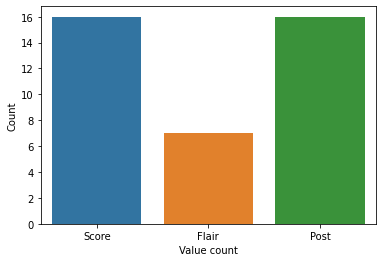

In [8]:
unique_authors = russia_df.nunique().reset_index()
unique_authors.loc[len(unique_authors.index)] = ['Post', russia_df.shape[0]]

unique_authors.drop([0, 1, 2, 4], inplace=True)
unique_authors.columns = ['Value count', 'Count']
ax = sns.barplot(data=unique_authors, x='Value count', y='Count')

On average, each author posted around three submissions to the community.

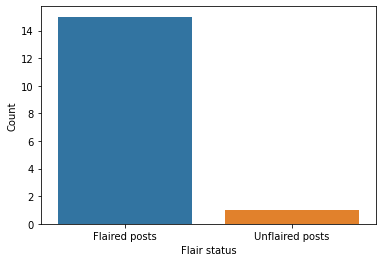

In [9]:
unflaired_posts = russia_df[russia_df.Flair == '']
flaired_posts = russia_df[russia_df.Flair != '']

post_flair_df = pd.DataFrame.from_dict({
  0: ['Flaired posts', len(flaired_posts)],
  1: ['Unflaired posts', len(unflaired_posts)]
}, orient='index')

post_flair_df.columns = ['Flair status', 'Count']
ax = sns.barplot(data=post_flair_df, x='Flair status', y='Count')

In [10]:
russia_df.corr(method='spearman')

,Number of Comments,Score
Number of Comments,1.000000,0.741176
Score,0.741176,1.000000


<AxesSubplot:>

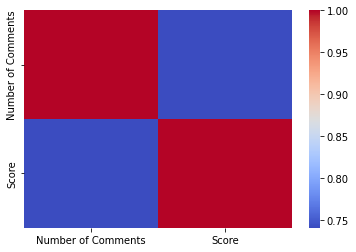

In [11]:
sns.heatmap(russia_df.corr(method='spearman'), cmap='coolwarm')

There is very little correlation between the Score and the Number of comments on a post. However, the correlation isn't negative either. This means the score and number of comments are hardly related to each other.

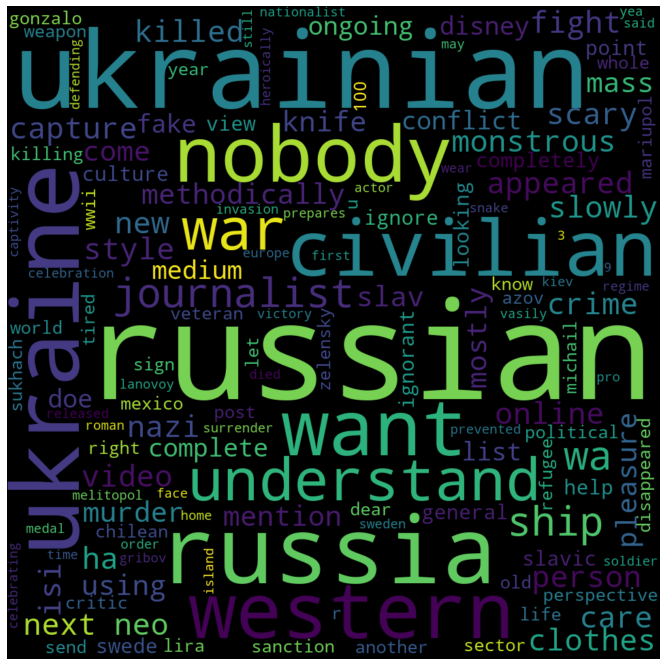

In [18]:
def get_wordnet_tag(tag):
    tag_mapping = {
        'ADJ': 'j',
        'VERB': 'v',
        'NOUN': 'n',
        'ADV': 'r'
    }

    if tag in tag_mapping:
        return tag_mapping[tag]
    else:
        return 'n'

def lemmatize(title):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    words = list()
    title = word_tokenize(title)
    for word, tag in pos_tag(title):
        tag = get_wordnet_tag(tag)
        word = lemmatizer.lemmatize(word, tag)
        if word not in stop_words:
            words.append(word)
    
    return ' '.join(words)

clean_russia_titles_df = russia_df.copy()
clean_russia_titles_df['Title'] = clean_russia_titles_df['Title'].str.lower()
clean_russia_titles_df['Title'] = clean_russia_titles_df['Title'].str.replace(r'[^\w\d\s]', ' ', regex=True)
clean_russia_titles_df['Title'] = clean_russia_titles_df['Title'].apply(lambda title: lemmatize(title))

def wordcloud(dataset, min_freq=1):
    bow = list()
    for title in dataset['Title']:
        bow += word_tokenize(title)
    
    word_freq = dict()
    counter = Counter(bow)
    for word, freq in counter.items():
        if freq >= min_freq:
            word_freq[word] = freq
    
    wc = WordCloud(width=1000, height=1000, background_color='black')
    wc = wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

wordcloud(clean_russia_titles_df)


#### Analyzing _www.reddit.com/r/ukraine_

In [19]:
ukraine_df = pd.read_csv('../data/ukraine_data.csv')
ukraine_col = ukraine_df.columns

print("Columns in the Ukrainian dataframe\n")
for i in range (len(ukraine_col)):
  print(f'{i}. {ukraine_col[i]}')

Columns in the Ukrainian dataframe

0. ID
1. Date_utc
2. Title
3. Body
4. Number of Comments
5. Score
6. Author
7. Link
8. Flair


The following columns will be dropped:
 - Date_utc,
 - ID,
 - Link

The following columns will be retained:
 - Title -- the primary component of a post that will play a role in sentiment analysis.
 - Number of Comments -- Indicate how interested the community is in the post's subject. Sometimes a higher number of comments may also indicate a highly controversial post.
 - Score -- How the community perceives the post (whether they agree with it or not, whether they think the post is relevant to the community)
 - Author -- Will be useful in determining how active the authors are in the community, based on how much they've been posting.
 - Flair -- Similar to the title, plays a role in obtaining a quick insight into the subject of the post.

In [20]:
ukraine_df.drop(columns=['Date_utc', 'ID', 'Link'], inplace=True)

ukraine_col = ukraine_df.columns
print("Columns retained:\n")
for i in range (len(ukraine_col)):
  print(f'{i}. {ukraine_col[i]}')

Columns retained:

0. Title
1. Body
2. Number of Comments
3. Score
4. Author
5. Flair


In [21]:
# Convert the flair column of rows with missing flair values into empty strings so that they don't get dropped, as unflaired posts are perfectly valid
ukraine_df.loc[ukraine_df['Flair'].isna(), 'Flair'] = ''
# Drop rows with missing/NaN values
ukraine_df.dropna(inplace=True)

print(f'Number of complete entries in the dataset: {ukraine_df.shape[0]}')
ukraine_df.describe()[1:]

Number of complete entries in the dataset: 42


,Number of Comments,Score
mean,935.523810,18561.357143
std,793.834204,25328.981311
min,0.000000,7101.000000
25%,295.250000,7973.500000
50%,749.500000,11178.500000
75%,1282.500000,19486.250000
max,3074.000000,165771.000000


On an average, each post has received around 158 comments, and the average score of a post lies around 1611 points.

In [22]:
number_of_entries = ukraine_df.shape[0]
unique_authors = ukraine_df['Author'].unique()

print(f'Number of unique authors who participated in the community: {len(unique_authors)}')
print(f' - Average number of posts made by each individual author: {round(number_of_entries/len(unique_authors))}')
print(f'Number of unique flairs used throughout the set of posts: {len(ukraine_df.Flair.unique())}')

Number of unique authors who participated in the community: 39
 - Average number of posts made by each individual author: 1
Number of unique flairs used throughout the set of posts: 10


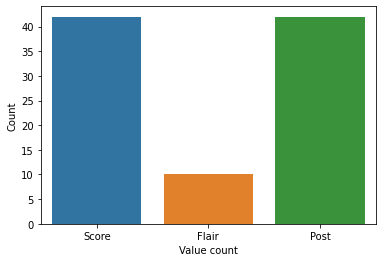

In [23]:
unique_authors = ukraine_df.nunique().reset_index()
unique_authors.loc[len(unique_authors.index)] = ['Post', ukraine_df.shape[0]]

unique_authors.drop([0, 1, 2, 4], inplace=True)
unique_authors.columns = ['Value count', 'Count']
ax = sns.barplot(data=unique_authors, x='Value count', y='Count')

On average, each author posted around two submissions to the community.

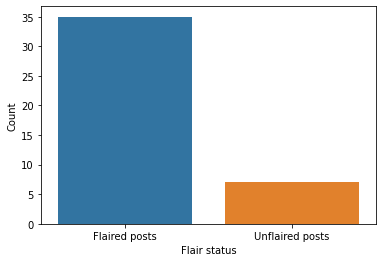

In [24]:
unflaired_posts = ukraine_df[ukraine_df.Flair == '']
flaired_posts = ukraine_df[ukraine_df.Flair != '']

post_flair_df = pd.DataFrame.from_dict({
  0: ['Flaired posts', len(flaired_posts)],
  1: ['Unflaired posts', len(unflaired_posts)]
}, orient='index')

post_flair_df.columns = ['Flair status', 'Count']
ax = sns.barplot(data=post_flair_df, x='Flair status', y='Count')

In [25]:
ukraine_df.corr(method='spearman')

,Number of Comments,Score
Number of Comments,1.000000,0.405835
Score,0.405835,1.000000


<AxesSubplot:>

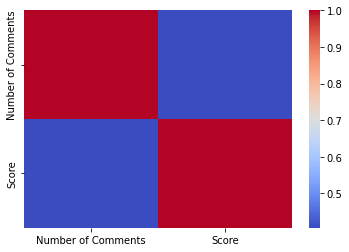

In [26]:
sns.heatmap(ukraine_df.corr(method='spearman'), cmap='coolwarm')

There is very little correlation between the Score and the Number of comments on a post (although it is slightly greater as compared to the russian dataset). However, the correlation isn't negative either. This means the score and number of comments are hardly related to each other.

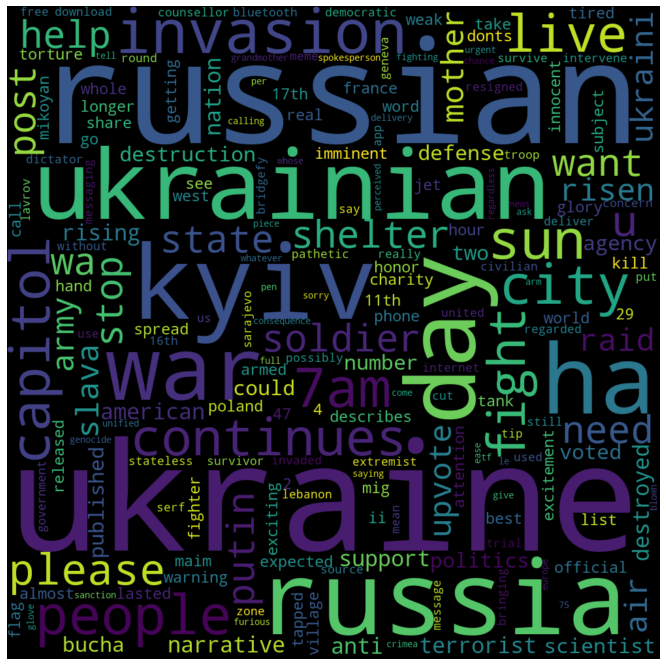

In [27]:
def get_wordnet_tag(tag):
    tag_mapping = {
        'ADJ': 'j',
        'VERB': 'v',
        'NOUN': 'n',
        'ADV': 'r'
    }

    if tag in tag_mapping:
        return tag_mapping[tag]
    else:
        return 'n'

def lemmatize(title):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    words = list()
    title = word_tokenize(title)
    for word, tag in pos_tag(title):
        tag = get_wordnet_tag(tag)
        word = lemmatizer.lemmatize(word, tag)
        if word not in stop_words:
            words.append(word)
    
    return ' '.join(words)

clean_ukraine_titles_df = ukraine_df.copy()
clean_ukraine_titles_df['Title'] = clean_ukraine_titles_df['Title'].str.lower()
clean_ukraine_titles_df['Title'] = clean_ukraine_titles_df['Title'].str.replace(r'[^\w\d\s]', ' ', regex=True)
clean_ukraine_titles_df['Title'] = clean_ukraine_titles_df['Title'].apply(lambda title: lemmatize(title))

def wordcloud(dataset, min_freq=1):
    bow = list()
    for title in dataset['Title']:
        bow += word_tokenize(title)
    
    word_freq = dict()
    counter = Counter(bow)
    for word, freq in counter.items():
        if freq >= min_freq:
            word_freq[word] = freq
    
    wc = WordCloud(width=1000, height=1000, background_color='black')
    wc = wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

wordcloud(clean_ukraine_titles_df)
